<a href="https://colab.research.google.com/github/a-panagiotic/NeuralNetworks-Unofficial/blob/main/Exercise_3_All.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Βαθιά μάθηση στο CIFAR-100

 Μαρίνος Τζανίκος 03113147, el13147@mail.ntua.gr

 Γιώργος Γκανάς 03116095, el16095@mail.ntua.gr
 
 Παναγιώτης Αϊβασιλιώτης 03116176, el16176@mail.ntua.gr

## Εισαγωγή και επισκόπηση του συνόλου δεδομένων

In [139]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [140]:
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

In [141]:
# load the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

In [142]:
print(x_train_all.shape)

(50000, 32, 32, 3)


Η κάθε ομάδα θα δουλέψει με ένα μοναδικό ξεχωριστό υποσύνολο του CIFAR-100
Στο επόμενο κελί, αντικαταστήστε την τιμή της μεταβλητής `team_seed` με τον αριθμό της ομάδας σας.

In [143]:
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 18

Στο επόμενο κελί μπορείτε να διαλέξετε το πλήθος των κατηγορίων σας: 20 (default), 40, 60 ή 80.

In [144]:
# select the number of classes
cifar100_classes_url = select_classes_number(80)

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [145]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [146]:
# print our classes
print(our_classes)

['apple', ' aquarium_fish', ' baby', ' bear', ' beaver', ' bee', ' beetle', ' bicycle', ' bottle', ' bowl', ' boy', ' bridge', ' bus', ' butterfly', ' camel', ' castle', ' caterpillar', ' cattle', ' clock', ' cockroach', ' couch', ' crab', ' crocodile', ' cup', ' dinosaur', ' dolphin', ' elephant', ' flatfish', ' forest', ' girl', ' hamster', ' house', ' lamp', ' lawn_mower', ' leopard', ' lizard', ' lobster', ' man', ' maple_tree', ' motorcycle', ' mountain', ' mouse', ' mushroom', ' otter', ' palm_tree', ' pear', ' pickup_truck', ' pine_tree', ' plain', ' plate', ' porcupine', ' rabbit', ' raccoon', ' ray', ' road', ' rocket', ' rose', ' sea', ' seal', ' shark', ' shrew', ' snail', ' snake', ' spider', ' squirrel', ' streetcar', ' sunflower', ' sweet_pepper', ' table', ' television', ' tiger', ' tractor', ' train', ' trout', ' turtle', ' wardrobe', ' whale', ' willow_tree', ' wolf', ' woman']


In [147]:
CLASSES_NUM=len(our_classes)

In [148]:
print(x_train_ds[1].shape)

(32, 32, 3)


6000
Train: X=(34000, 32, 32, 3), y=(34000, 1)
Validation: X=(6000, 32, 32, 3), y=(6000, 1)
Test: X=(8000, 32, 32, 3), y=(8000, 1)


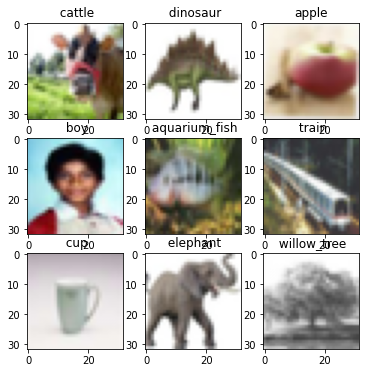

In [149]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

print(len(x_val))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

## Συναρτήσεις εκπαίδευσης

Θα χρησιμοποιήσουμε την ιδιότητα data prefetch του tf2:

In [150]:


# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(x,y, BATCH_SIZE):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

def train_model(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds, 
                      epochs=epochs, 
                      steps_per_epoch=steps_per_epoch, 
                      validation_data=validation_ds, 
                      validation_steps=validation_steps)
  return(history)

## Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

In [151]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
# print test set evaluation metrics
def model_evaluation(model, evaluation_steps):
	print('\nTest set evaluation metrics')
	loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps = 10):
	plt = summarize_diagnostics(history)
	plt.show()
	model_evaluation(model, evaluation_steps)

## Μοντέλα δικτύων

### Ένα μικρό συνελικτικό δίκτυο "from scratch"

In [152]:
# a simple CNN https://www.tensorflow.org/tutorials/images/cnn

def init_simple_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [153]:
SIMPLE_MODEL = init_simple_model(summary = True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 64)               

Epoch 1/200
30/30 [==============================] - 2s 39ms/step - loss: 4.6006 - accuracy: 0.0117 - val_loss: 4.5906 - val_accuracy: 0.0141
Epoch 2/200
30/30 [==============================] - 0s 17ms/step - loss: 4.5830 - accuracy: 0.0177 - val_loss: 4.5565 - val_accuracy: 0.0109
Epoch 3/200
30/30 [==============================] - 1s 19ms/step - loss: 4.5486 - accuracy: 0.0129 - val_loss: 4.5360 - val_accuracy: 0.0078
Epoch 4/200
30/30 [==============================] - 1s 18ms/step - loss: 4.5173 - accuracy: 0.0197 - val_loss: 4.4958 - val_accuracy: 0.0219
Epoch 5/200
30/30 [==============================] - 1s 19ms/step - loss: 4.4841 - accuracy: 0.0219 - val_loss: 4.4310 - val_accuracy: 0.0375
Epoch 6/200
30/30 [==============================] - 1s 20ms/step - loss: 4.4206 - accuracy: 0.0358 - val_loss: 4.3921 - val_accuracy: 0.0391
Epoch 7/200
30/30 [==============================] - 1s 30ms/step - loss: 4.3665 - accuracy: 0.0290 - val_loss: 4.3047 - val_accuracy: 0.0328
Epoch 

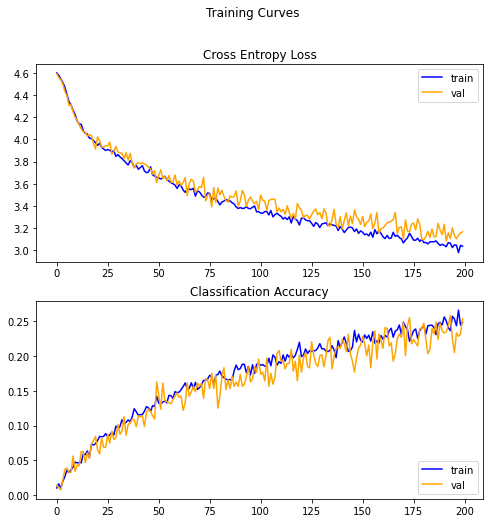


Test set evaluation metrics
30/30 [==============================] - 0s 4ms/step - loss: 3.1124 - accuracy: 0.2260
loss: 3.11
accuracy: 0.23


In [154]:
SIMPLE_MODEL_history = train_model(SIMPLE_MODEL, 200, 30, 5)
model_report(SIMPLE_MODEL, SIMPLE_MODEL_history, 30)

### Πιο περίπλοκο συνελικτικό δίκτυο "from scratch"

In [155]:
def train_model_v1(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
  history = model.fit_generator(train_ds, 
                      epochs=epochs, 
                      steps_per_epoch=steps_per_epoch, 
                      validation_data=validation_ds, 
                      validation_steps=validation_steps,
                      callbacks=[callback])
  return(history)

In [156]:
def init_cnn_model(summary):
  model = models.Sequential()
  
  model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same', input_shape=(32,32,3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='elu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  
  
  model.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(256, (3, 3), activation='elu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(512, (3, 3), activation='elu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(512, (3, 3), activation='elu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  
  model.add(layers.Flatten())
  
  model.add(layers.Dense(1024, activation='elu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [157]:
CNN_MODEL = init_cnn_model(summary = True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 128)       512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 256)      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
60/60 [==============================] - 5s 48ms/step - loss: 5.5166 - accuracy: 0.0352 - val_loss: 5.0930 - val_accuracy: 0.0156
Epoch 2/200
60/60 [==============================] - 3s 43ms/step - loss: 4.7027 - accuracy: 0.0841 - val_loss: 5.8669 - val_accuracy: 0.0203
Epoch 3/200
60/60 [==============================] - 3s 43ms/step - loss: 4.3073 - accuracy: 0.1208 - val_loss: 6.1364 - val_accuracy: 0.0109
Epoch 4/200
60/60 [==============================] - 3s 44ms/step - loss: 4.1325 - accuracy: 0.1403 - val_loss: 6.1594 - val_accuracy: 0.0375
Epoch 5/200
60/60 [==============================] - 3s 43ms/step - loss: 4.0135 - accuracy: 0.1483 - val_loss: 5.7429 - val_accuracy: 0.0437
Epoch 6/200
60/60 [==============================] - 3s 43ms/step - loss: 3.7521 - accuracy: 0.1715 - val_loss: 4.9408 - val_accuracy: 0.0750
Epoch 7/200
60/60 [==============================] - 3s 43ms/step - loss: 3.6601 - accuracy: 0.1939 - val_loss: 4.3575 - val_accuracy: 0.1156
Epoch 

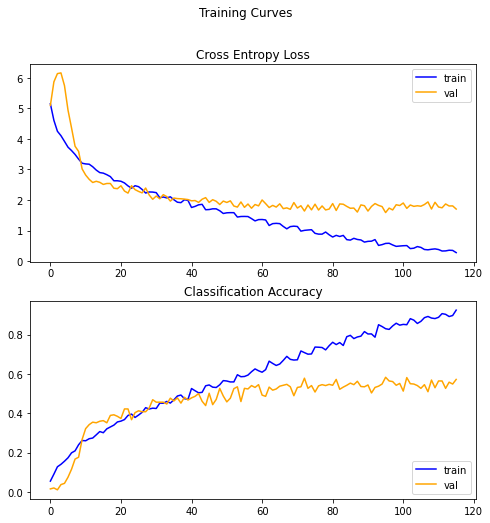


Test set evaluation metrics
30/30 [==============================] - 1s 14ms/step - loss: 1.7990 - accuracy: 0.5409
loss: 1.80
accuracy: 0.54


In [158]:
CNN_MODEL_history = train_model_v1(CNN_MODEL, 200, 60, 5)
model_report(CNN_MODEL, CNN_MODEL_history, 30)

### Μεταφορά μάθησης: MobileNet V2

In [159]:
#define different train_model function for MobileNet in order to use early stopping
def my_train_model(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks = [callback], validation_data=validation_ds, validation_steps=validation_steps)
  return(history)

In [160]:
#                                                *** MobileNet v2 ***

def my_train_model(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks = [callback], validation_data=validation_ds, validation_steps=validation_steps)
  return(history)  

mobilenet_v2_model=tf.keras.applications.MobileNetV2(input_shape=(32,32,3), include_top=False, weights='imagenet')
MOBILENET_V2_MODEL=mobilenet_v2_model.layers[0](mobilenet_v2_model)
MOBILENET_V2_MODEL.trainable=False
#mobilenet_v2_model.trainable=False

dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  # add top layer for CIFAR100 classification
prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')

def init_MOBILENET_V2_model(summary):  
  model = tf.keras.Sequential([MOBILENET_V2_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

9412608/9406464 [==============================] - 0s 0us/step


In [161]:
import time
train_time_mbn2 = 0
my_MOBILENET_V2_MODEL = init_MOBILENET_V2_model(True)
start_time_mbn2 = time.time()
MOBILENET_V2_MODEL_history = my_train_model(my_MOBILENET_V2_MODEL, 60, 90, 10)
train_time_mbn2 += time.time() - start_time_mbn2

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1, 1, 1280)        2257984   
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 1, 1280)        0         
_________________________________________________________________
global_average_pooling2d_17  (None, 1280)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 100)               128100    
Total params: 2,386,084
Trainable params: 128,100
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/60
90/90 [==============================] - 6s 30ms/step - loss: 4.6144 - accuracy: 0.0124 - val_loss: 4.5985 - val_accuracy: 0.0055
Epoch 2/60
90/90 [==============================] - 2s 17ms/step - loss: 4.6034 - accuracy: 0.0

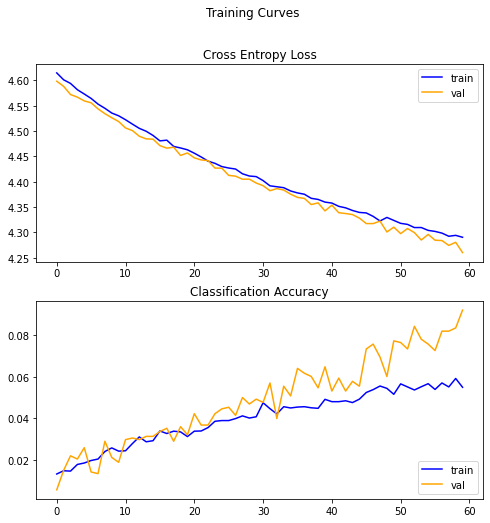


Test set evaluation metrics
10/10 [==============================] - 0s 12ms/step - loss: 4.2756 - accuracy: 0.0828
loss: 4.28
accuracy: 0.08


In [162]:
model_report(my_MOBILENET_V2_MODEL, MOBILENET_V2_MODEL_history)

In [163]:
MOBILENET_V2_MODEL.trainable=True
my_MOBILENET_V2_MODEL = init_MOBILENET_V2_model(True)
start_time_mbn2 = time.time()
MOBILENET_V2_MODEL_history_2 = my_train_model(my_MOBILENET_V2_MODEL, 60, 70, 10)
train_time_mbn2 += time.time() - start_time_mbn2

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1, 1, 1280)        2257984   
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 1, 1280)        0         
_________________________________________________________________
global_average_pooling2d_17  (None, 1280)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 100)               128100    
Total params: 2,386,084
Trainable params: 2,351,972
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/60
70/70 [==============================] - 8s 44ms/step - loss: 6.5590 - accuracy: 0.0167 - val_loss: 4.2917 - val_accuracy: 0.0656
Epoch 2/60
70/70 [==============================] - 2s 32ms/step - loss: 5.5176 - accuracy: 0.01

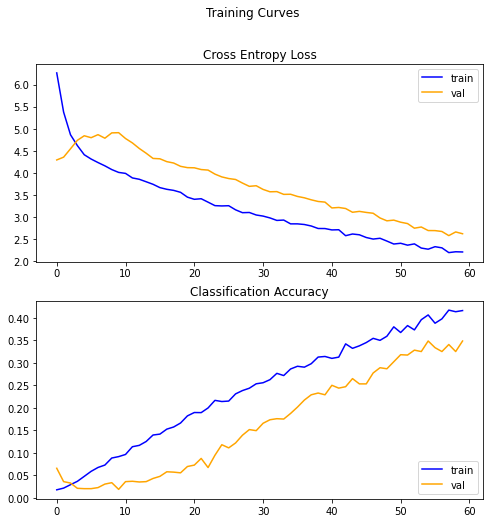


Test set evaluation metrics
10/10 [==============================] - 0s 12ms/step - loss: 2.6063 - accuracy: 0.3297
loss: 2.61
accuracy: 0.33


In [164]:
model_report(my_MOBILENET_V2_MODEL, MOBILENET_V2_MODEL_history_2)

In [165]:
print("Total train time for MobileNetV2 : ", train_time_mbn2)

Total train time for MobileNetV2 :  236.71010565757751


### Μεταφορά μάθησης: VGG19

In [ ]:
#change Batch size and define different train_model function for VGG19 (different early stopping)

BATCH_SIZE = 256 #128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(x,y, BATCH_SIZE):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

def train_model(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps, callbacks=[callback])
  return(history)

In [130]:
# transfer learning: VGG19 trained on ImageNet without the top layer

vgg19_model=tf.keras.applications.VGG19(include_top=False, input_shape=(32,32,3),  weights='imagenet')

# freeze conv layers
vgg19_model.trainable=False

dropout_layer = tf.keras.layers.Dropout(rate = 0.1)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#define data augmentation layers

flip_layer = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")

# add top layer for CIFAR100 classification
prediction_layer1 = tf.keras.layers.Dense(512, activation='relu')
prediction_layer2 = tf.keras.layers.Dense(512, activation='relu')
prediction_layer3 = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')

In [129]:
def build_model(summary):

  inputs = tf.keras.Input(shape=(32, 32, 3))
  x = flip_layer(inputs)
  x = vgg19_model(x)
  x = dropout_layer(x)
  x = global_average_layer(x)
  x = prediction_layer1(x)
  x = prediction_layer2(x)
  outputs = prediction_layer3(x)
  model = tf.keras.Model(inputs, outputs)

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00020), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
random_flip_8 (RandomFlip)   (None, 32, 32, 3)         0         
_________________________________________________________________
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
dropout_23 (Dropout)         (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_15  (None, 512)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_54 (Dense)             (None, 512)               262

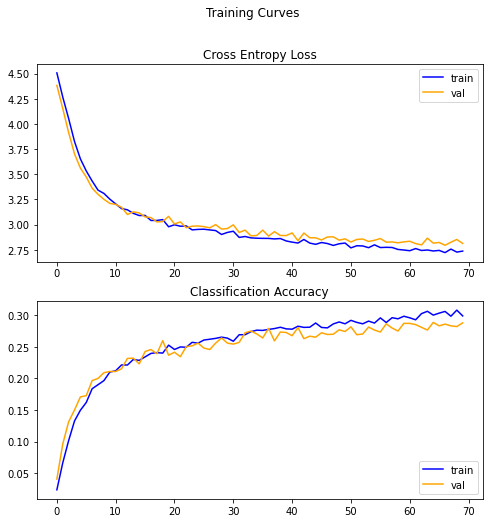


Test set evaluation metrics
30/30 [==============================] - 1s 21ms/step - loss: 2.7556 - accuracy: 0.3016
loss: 2.76
accuracy: 0.30


In [125]:
import time

VGG19_MODEL = build_model(True)
start_time = time.time()
VGG19_MODEL_history = train_model(VGG19_MODEL, 70, 40, 10)
train_time = time.time() - start_time

model_report(VGG19_MODEL, VGG19_MODEL_history, 30)

In [133]:
# unfreeze conv layers
vgg19_model.trainable=True

# Fine-tune from this layer onwards
fine_tune_at = 0

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg19_model.layers[:fine_tune_at]:
  layer.trainable =  False

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
random_flip_8 (RandomFlip)   (None, 32, 32, 3)         0         
_________________________________________________________________
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
dropout_23 (Dropout)         (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_15  (None, 512)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_54 (Dense)             (None, 512)               262

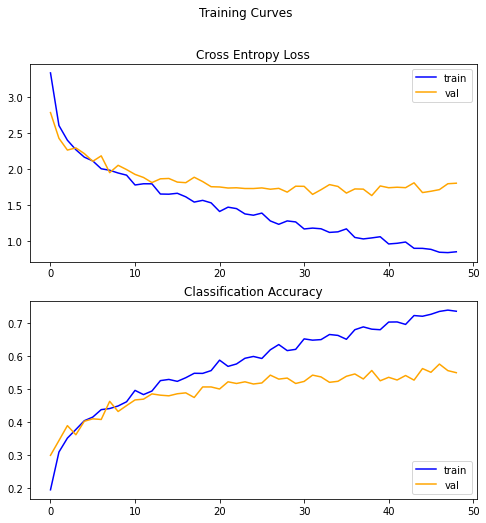


Test set evaluation metrics
30/30 [==============================] - 1s 21ms/step - loss: 1.6431 - accuracy: 0.5612
loss: 1.64
accuracy: 0.56


In [127]:
VGG19_MODEL = build_model(True)
start_time = time.time()
VGG19_MODEL_history = train_model(VGG19_MODEL, 70, 40, 10)
train_time += time.time() - start_time

model_report(VGG19_MODEL, VGG19_MODEL_history, 30)

In [135]:
train_time

247.40809559822083

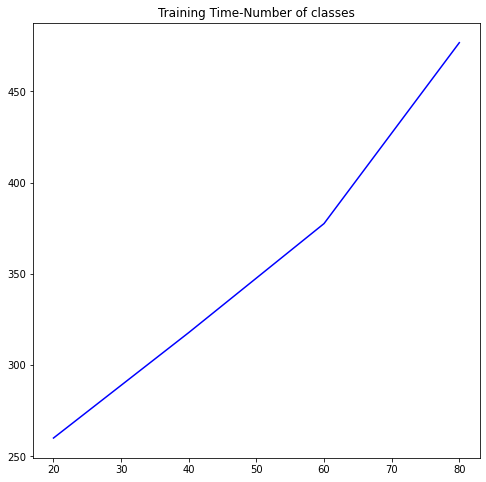

In [68]:
batches = [20, 40, 60, 80]
plt.figure(figsize=(8, 8))

plt.title('Training Time-Number of classes')
plt.plot(batches, [259.98320174217224, 317.8090891838074, 377.57119035720825, 476.7510085105896], color='blue', label='train')
#plt.plot(batches, [0.7326, 0.5900, 0.5635, 0.5047], color='orange', label='test')
#plt.legend(loc='upper right')
